Dataset Size: 200
   age  sex  cp    trestbps        chol  fbs  restecg     thalach  exang  \
0   66    1   3  167.083933  227.544226    1        2  161.511521      0   
1   55    1   2  165.027957  260.030511    1        2  105.561616      1   
2   62    1   2  142.227338  228.690914    1        2  113.251117      1   
3   36    1   3  120.642025  238.484031    1        0  154.031149      0   
4   37    0   2  142.682087  194.224846    0        2  151.425246      1   

    oldpeak  slope  ca  thal  target  
0  2.424789      0   0     1       1  
1  1.286288      1   3     2       1  
2  2.090486      1   2     2       1  
3  3.365221      2   1     2       1  
4  1.589874      2   1     2       1  
Best Parameters found by GridSearchCV:
{'model__metric': 'manhattan', 'model__n_neighbors': 5, 'model__p': 1, 'model__weights': 'distance'}
Confusion Matrix:
[[21  3]
 [ 9 15]]
F1 Score: 0.7142857142857143
Accuracy Score: 0.75
ROC AUC Score: 0.7881944444444444
Classification Report:
       

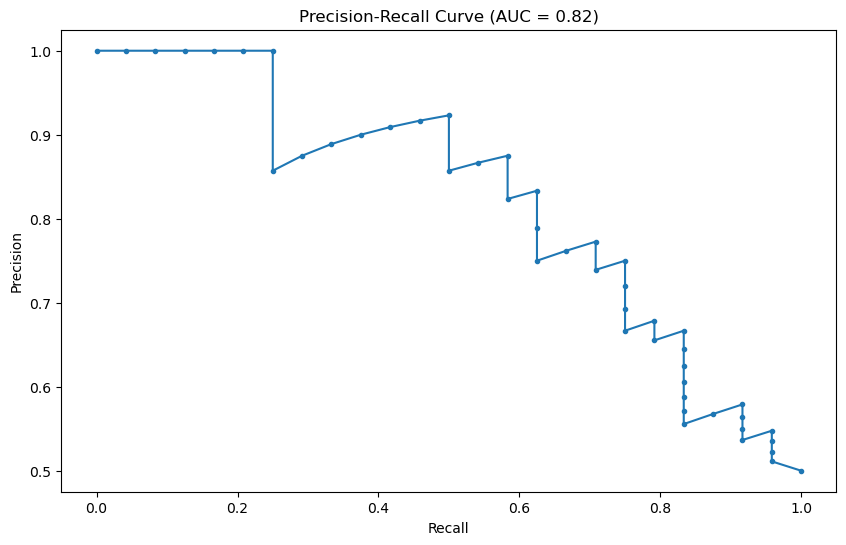

Cross-Validation Accuracy Scores: [0.63157895 0.71052632 0.65789474 0.60526316 0.68421053]
Mean Cross-Validation Accuracy: 0.6578947368421052
Random Forest Performance:
Accuracy Score: 0.6875
F1 Score: 0.6511627906976745
ROC AUC Score: 0.7803819444444444
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.79      0.72        24
           1       0.74      0.58      0.65        24

    accuracy                           0.69        48
   macro avg       0.70      0.69      0.68        48
weighted avg       0.70      0.69      0.68        48



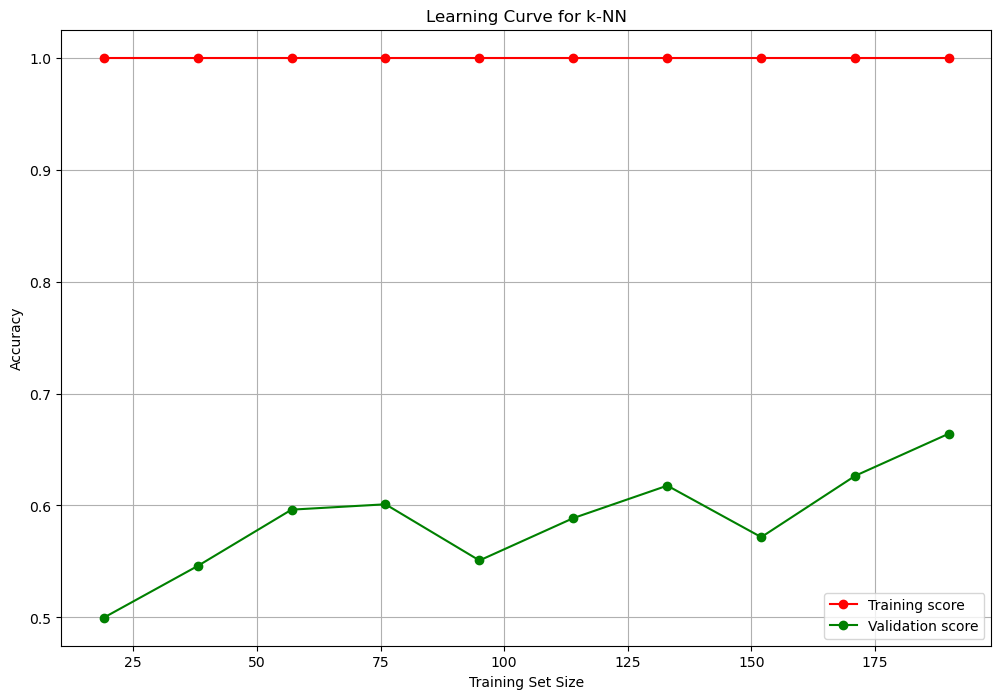

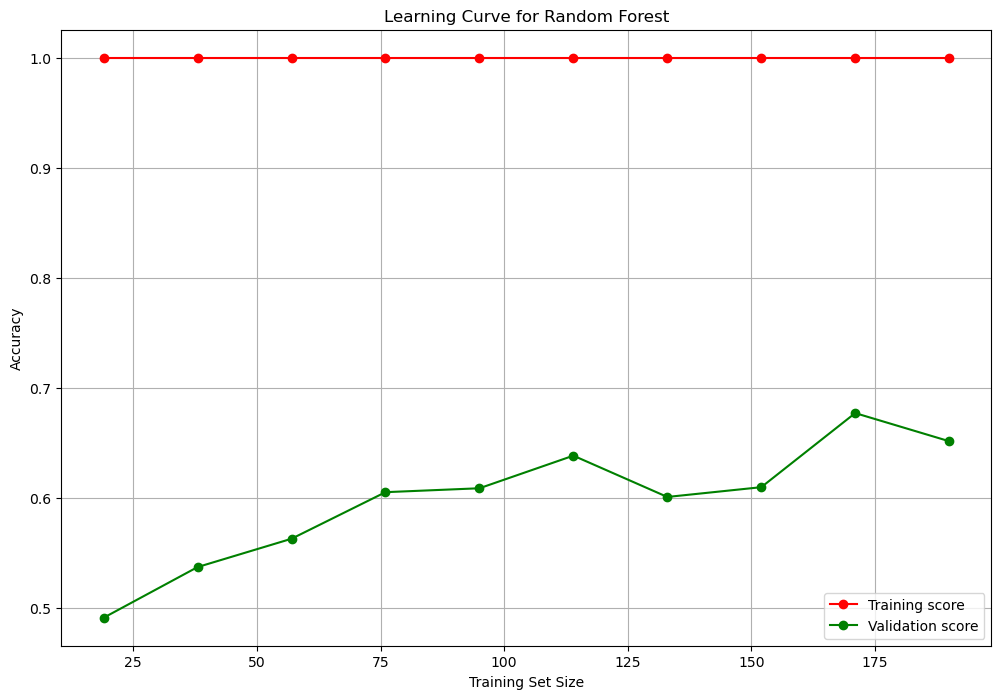

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Load the dataset
large_df = pd.read_csv("C:/Users/adams/Downloads/large_heart_disease.csv")

# Convert age column to integer type
large_df["age"] = large_df["age"].astype(int)

# Optional: Save the modified dataset
large_df.to_csv("modified_large_heart_disease.csv", index=False)

# Display the dataset size and first few rows
print(f"Dataset Size: {len(large_df)}")
print(large_df.head())

# Feature matrix (X) and target vector (y)
X = large_df.iloc[:, 0:8]
y = large_df.iloc[:, 8]

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=0)
X, y = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y)

# Preprocessing and Feature Selection Pipeline
scaler = StandardScaler()
pca = PCA(n_components=0.95)  # Keep 95% variance
feature_selector = SelectKBest(score_func=f_classif, k=5)  # Select top 5 features

# Define the k-NN model
knn = KNeighborsClassifier()

# Create a pipeline with scaling, PCA, feature selection, and model training
pipeline = SkPipeline([
    ('scaling', scaler),
    ('pca', pca),
    ('feature_selection', feature_selector),
    ('model', knn)
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'model__n_neighbors': [3, 5, 7, 11, 13],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan', 'minkowski'],
    'model__p': [1, 2]  # Used for Minkowski distance
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
print("Best Parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Using the best found parameters for the final model
best_pipeline = grid_search.best_estimator_

# Train the final model
best_pipeline.fit(X_train, y_train)

# Predicting the test set results
y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# F1 Score
print("F1 Score:", f1_score(y_test, y_pred))

# Accuracy Score
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# ROC AUC Score (for binary classification)
if len(np.unique(y)) == 2:  # Only calculate ROC AUC for binary classification
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Detailed Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.show()

# Cross-validation score (optional)
cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

# Ensemble Method: Adding Random Forest for comparison
ensemble_pipeline = ImPipeline([
    ('scaling', scaler),
    ('pca', pca),
    ('feature_selection', feature_selector),
    ('model', RandomForestClassifier(n_estimators=100, random_state=0))
])

ensemble_pipeline.fit(X_train, y_train)
y_pred_ensemble = ensemble_pipeline.predict(X_test)
y_pred_ensemble_proba = ensemble_pipeline.predict_proba(X_test)[:, 1]

# Comparing the performance of Random Forest
print("Random Forest Performance:")
print("Accuracy Score:", accuracy_score(y_test, y_pred_ensemble))
print("F1 Score:", f1_score(y_test, y_pred_ensemble))
if len(np.unique(y)) == 2:
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_ensemble_proba))
print("Classification Report:")
print(classification_report(y_test, y_pred_ensemble))

# Function to plot learning curves
def plot_learning_curve(pipeline, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        pipeline, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.figure(figsize=(12, 8))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation score')
    plt.title(title)
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Plot learning curves for k-NN
plot_learning_curve(best_pipeline, X, y, 'Learning Curve for k-NN')

# Plot learning curves for Random Forest
plot_learning_curve(ensemble_pipeline, X, y, 'Learning Curve for Random Forest')